starting multi-armed bandit experiments...
recreating figures from sutton & barto chapter 2

=== UCB vs ε-greedy comparison ===
running ucb vs epsilon-greedy experiments...


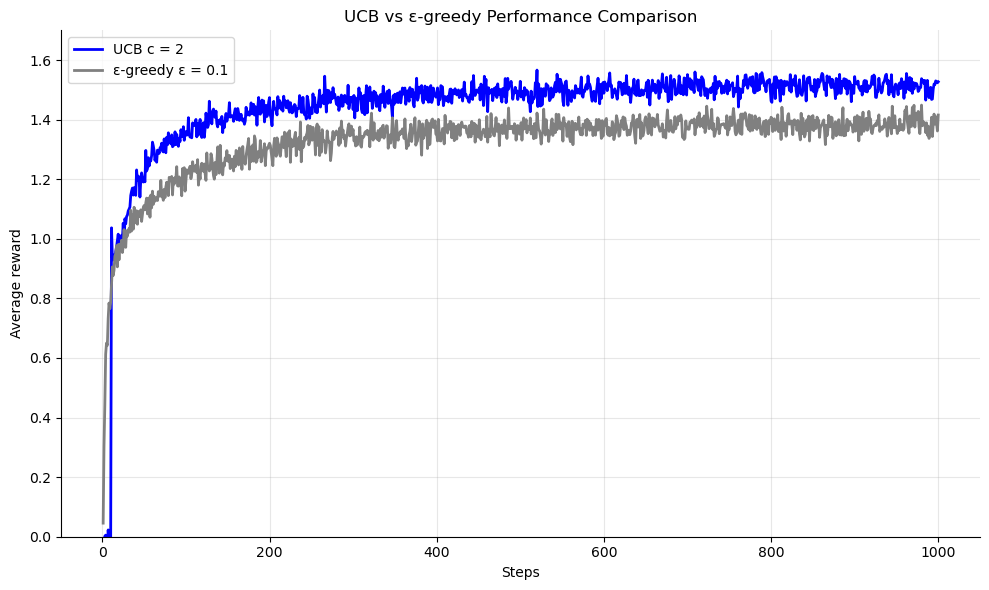


=== optimistic vs realistic initial values ===
running optimistic vs realistic experiments...


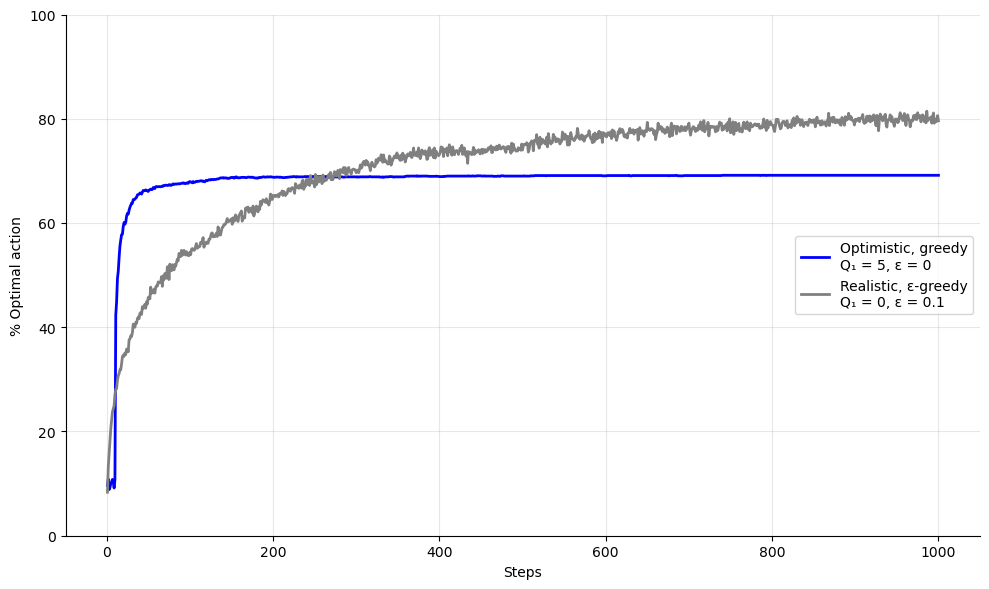

final optimistic performance: 69.2%
final realistic performance: 79.6%
from notes: optimistic starts worse due to exploration, catches up initially,
but realistic eventually surpasses due to continued ε-exploration


=== debugging single optimistic run ===
true optimal arm: 9, value: 1.318
all true values: ['0.40', '0.14', '-0.10', '-1.60', '0.53', '-1.01', '-0.63', '-1.72', '1.14', '1.32']

initial Q-values: all = 5.0 (optimistic)
first 15 steps showing 'disappointment' effect:
step  1: chose arm 0, reward=-0.32, Q[0]: 5.00→-0.32, optimal?=False
step  2: chose arm 1, reward= 0.13, Q[1]: 5.00→0.13, optimal?=False
step  3: chose arm 2, reward=-1.07, Q[2]: 5.00→-1.07, optimal?=False
step  4: chose arm 3, reward=-1.89, Q[3]: 5.00→-1.89, optimal?=False
step  5: chose arm 4, reward=-0.59, Q[4]: 5.00→-0.59, optimal?=False
step  6: chose arm 5, reward=-1.30, Q[5]: 5.00→-1.30, optimal?=False
step  7: chose arm 6, reward=-0.46, Q[6]: 5.00→-0.46, optimal?=False
step  8: chose arm 7, reward=-1.58

In [3]:
# Niveen Abdul-Mohsen (bvn9ad)
# Reinforcement Learning (CS 4771) - Multi-armed Bandit Experiments (CORRECTED VERSION)
# This code recreates the textbook figures comparing UCB vs epsilon-greedy
# and optimistic vs realistic epsilon-greedy strategies
# using numpy for numerical operations and matplotlib for plotting

import numpy as np
import matplotlib.pyplot as plt


def create_bandit_problem(num_arms, true_mean=0, true_std=1):
    """
    create a bandit problem by generating true action values q*(a)
    
    from notes: "each of the k actions has an expected/mean reward, called the value of the action"
    for the testbed, true values are randomly chosen from normal distribution with mean 0 and variance 1
    each arm gets a random true value that represents its expected reward
    """
    true_values = np.random.normal(true_mean, true_std, num_arms)
    optimal_arm = np.argmax(true_values)  # the arm with highest true value
    return true_values, optimal_arm


def get_reward(true_value, reward_std=1):
    """
    get a noisy reward from an arm with given true value
    
    from notes: "when the agent picks an action At, it receives a reward Rt picked randomly 
    from a normal distribution whose mean is q*(At) and variance 1"
    this adds gaussian noise to simulate real-world uncertainty
    """
    return np.random.normal(true_value, reward_std)


def epsilon_greedy_action(Q_values, epsilon):
    """
    choose action using epsilon-greedy strategy
    
    from notes: "in ε-greedy methods, at each step:
    - with probability 1−ε, the action with the highest estimated value (greedy) is selected
    - with probability ε, a random action is picked from all possible actions"
    
    this balances exploitation (using current knowledge) vs exploration (trying new things)
    """
    if np.random.rand() < epsilon:
        # explore: pick random action to improve estimates
        return np.random.choice(len(Q_values))
    else:
        # exploit: pick action with highest estimated value (greedy choice)
        # break ties randomly if multiple actions have same max value
        max_value = np.max(Q_values)
        best_actions = np.where(Q_values == max_value)[0]
        return np.random.choice(best_actions)


def ucb_action(Q_values, action_counts, timestep, c=1.5):
    """
    choose action using upper confidence bound strategy
    
    from notes: "UCB picks actions not just by estimated reward Qt(a) but also by uncertainty
    if an action's value is uncertain (chosen rarely), it gets a bonus for uncertainty"
    
    formula: At = argmax[Qt(a) + c * sqrt(ln(t) / Nt(a))]
    this balances exploitation with focused exploration of uncertain actions
    """
    num_arms = len(Q_values)
    
    # if any action hasn't been tried, pick one of those first
    # from notes: "every action is sampled at least once since untried action has infinite bonus"
    untried_actions = np.where(action_counts == 0)[0]
    if len(untried_actions) > 0:
        return np.random.choice(untried_actions)
    
    # calculate ucb values for all actions
    # Qt(a) + confidence bonus based on uncertainty
    ucb_values = np.zeros(num_arms)
    for arm in range(num_arms):
        # confidence bonus gets smaller as action is tried more (uncertainty decreases)
        confidence_bonus = c * np.sqrt(np.log(timestep) / action_counts[arm])
        ucb_values[arm] = Q_values[arm] + confidence_bonus
    
    # pick action with highest ucb value (high reward OR high uncertainty)
    return np.argmax(ucb_values)


def update_q_value(current_q, reward, count):
    """
    update action value estimate using sample average method
    
    from notes: "incremental update formula: Qn+1 = Qn + (1/n) * (Rn - Qn)"
    this is the pattern: NewEstimate = OldEstimate + StepSize * [Target - OldEstimate]
    where step size = 1/count gets smaller as we collect more samples
    """
    step_size = 1.0 / count  # sample average step size
    error = reward - current_q  # difference between observed and expected
    return current_q + step_size * error


def run_bandit_experiment(algorithm, num_arms, num_steps, initial_q=0, **kwargs):
    """
    run a single bandit experiment with specified algorithm
    
    from notes: "a learning algorithm tries to learn which actions give best rewards
    by repeatedly choosing actions over many time steps"
    
    tracks rewards received and whether optimal action was chosen at each step
    """
    # set up the bandit problem - create true action values q*(a)
    true_values, optimal_arm = create_bandit_problem(num_arms)
    
    # initialize action-value estimates Qt(a) and counters
    Q_values = np.full(num_arms, initial_q, dtype=float)  # estimated values
    action_counts = np.zeros(num_arms, dtype=int)  # how many times each arm chosen
    
    # tracking arrays for performance analysis
    rewards = np.zeros(num_steps)
    optimal_actions = np.zeros(num_steps, dtype=bool)
    
    # run the experiment step by step
    for step in range(num_steps):
        # choose action based on algorithm strategy
        if algorithm == 'epsilon_greedy':
            action = epsilon_greedy_action(Q_values, kwargs['epsilon'])
        elif algorithm == 'ucb':
            action = ucb_action(Q_values, action_counts, step + 1, kwargs.get('c', 2))
        else:
            raise ValueError(f"unknown algorithm: {algorithm}")
        
        # take action and observe reward from environment
        reward = get_reward(true_values[action])
        rewards[step] = reward
        optimal_actions[step] = (action == optimal_arm)  # track if we picked best arm
        
        # update our estimate of this action's value using incremental update
        action_counts[action] += 1
        Q_values[action] = update_q_value(Q_values[action], reward, action_counts[action])
    
    return rewards, optimal_actions


def run_multiple_experiments(algorithm, num_runs, num_arms, num_steps, **kwargs):
    """
    run multiple independent experiments and collect results
    
    from notes: "this process (called a run) is repeated for thousands of different 
    random problems to measure how well the algorithm learns on average"
    
    averages across runs to get reliable performance measures
    """
    all_rewards = np.zeros((num_runs, num_steps))
    all_optimal = np.zeros((num_runs, num_steps))
    
    for run in range(num_runs):
        rewards, optimal = run_bandit_experiment(algorithm, num_arms, num_steps, **kwargs)
        all_rewards[run] = rewards
        all_optimal[run] = optimal
    
    return all_rewards, all_optimal


def create_ucb_vs_epsilon_plot():
    """
    recreate figure showing ucb vs epsilon-greedy comparison
    
    from notes: "UCB generally performs better than ε-greedy, except possibly 
    for the very first k steps where it's still exploring all options"
    
    demonstrates ucb's superior long-term performance due to focused exploration
    """
    # experiment parameters for 10-armed testbed
    num_runs = 2000  # enough runs to get smooth average performance
    num_arms = 10    # standard testbed setup
    num_steps = 1000 # track performance over 1000 steps
    
    print("running ucb vs epsilon-greedy experiments...")
    
    # run ucb experiment with confidence parameter c=1.5

    # from notes: "c controls degree of exploration, larger c = more exploration"
    ucb_rewards, ucb_optimal = run_multiple_experiments(
        'ucb', num_runs, num_arms, num_steps, c=1.5
    )
    
    # run epsilon-greedy experiment with standard ε=0.1
    # from notes: "ε=0.1 means 10% random exploration, 90% greedy exploitation"
    eps_rewards, eps_optimal = run_multiple_experiments(
        'epsilon_greedy', num_runs, num_arms, num_steps, epsilon=0.1
    )
    
    # calculate average performance across all runs
    ucb_avg_rewards = np.mean(ucb_rewards, axis=0)
    eps_avg_rewards = np.mean(eps_rewards, axis=0)
    
    # create the plot matching textbook style
    plt.figure(figsize=(10, 6))
    steps = np.arange(1, num_steps + 1)
    
    plt.plot(steps, ucb_avg_rewards, 'b-', label='UCB c = 2', linewidth=2)
    plt.plot(steps, eps_avg_rewards, 'gray', label='ε-greedy ε = 0.1', linewidth=2)
    
    plt.xlabel('Steps')
    plt.ylabel('Average reward')
    plt.legend()
    plt.title('UCB vs ε-greedy Performance Comparison')
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 1.7)
    
    # styling to match textbook figures
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    
    plt.tight_layout()
    plt.show()


def create_optimistic_vs_realistic_plot():
    """
    recreate figure showing optimistic vs realistic initial values
    
    from notes: "optimistic initial values encourage exploration. setting Q1(a) = +5 
    makes agent optimistic about untried actions. as actions are chosen and rewards 
    are usually lower than optimistic estimates, agent gets 'disappointed' and tries others"
    
    key insight: optimistic method explores early then plateaus, realistic method 
    continues improving due to persistent ε-exploration
    """
    # experiment parameters
    num_runs = 2000
    num_arms = 10
    num_steps = 1000
    
    print("running optimistic vs realistic experiments...")
    
    # optimistic greedy: high initial values, pure greedy (no ε)
    # from notes: "Q1(a) = +5 if rewards are around 0, makes all actions seem attractive initially"
    # "pure greedy selection but explores due to optimistic disappointment"
    opt_rewards, opt_optimal = run_multiple_experiments(
        'epsilon_greedy', num_runs, num_arms, num_steps, 
        epsilon=0.0, initial_q=5.0  # no forced exploration, high initial estimates
    )
    
    # realistic ε-greedy: zero initial values, ε=0.1 exploration
    # from notes: "Q1(a) = 0, ε = 0.1 means forced random exploration occasionally"
    real_rewards, real_optimal = run_multiple_experiments(
        'epsilon_greedy', num_runs, num_arms, num_steps,
        epsilon=0.1, initial_q=0.0  # standard setup with forced exploration
    )
    
    # calculate percentage of optimal actions chosen
    opt_pct_optimal = np.mean(opt_optimal, axis=0) * 100
    real_pct_optimal = np.mean(real_optimal, axis=0) * 100
    
    # create the plot matching textbook figure 2.3
    plt.figure(figsize=(10, 6))
    steps = np.arange(1, num_steps + 1)
    
    # colors and labels to match textbook
    plt.plot(steps, opt_pct_optimal, 'b-', 
             label='Optimistic, greedy\nQ₁ = 5, ε = 0', linewidth=2)
    plt.plot(steps, real_pct_optimal, color='gray', 
             label='Realistic, ε-greedy\nQ₁ = 0, ε = 0.1', linewidth=2)
    
    plt.xlabel('Steps')
    plt.ylabel('% Optimal action')
    plt.legend(loc='center right')  # position legend to match textbook
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 100)
    
    # styling to match textbook figures
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # print some analysis to understand the behavior
    print(f"final optimistic performance: {opt_pct_optimal[-1]:.1f}%")
    print(f"final realistic performance: {real_pct_optimal[-1]:.1f}%")
    print("from notes: optimistic starts worse due to exploration, catches up initially,")
    print("but realistic eventually surpasses due to continued ε-exploration")


def debug_single_optimistic_run():
    """
    debug function to understand optimistic behavior in detail
    shows what happens in first few steps of optimistic initialization
    """
    print("\n=== debugging single optimistic run ===")
    
    # create a bandit problem
    true_values, optimal_arm = create_bandit_problem(10)
    print(f"true optimal arm: {optimal_arm}, value: {true_values[optimal_arm]:.3f}")
    print(f"all true values: {[f'{v:.2f}' for v in true_values]}")
    
    # start with optimistic values
    Q_values = np.full(10, 5.0)  # all actions look great initially
    action_counts = np.zeros(10)
    
    print(f"\ninitial Q-values: all = 5.0 (optimistic)")
    print("first 15 steps showing 'disappointment' effect:")
    
    for step in range(15):
        # greedy action selection
        action = np.argmax(Q_values)
        reward = get_reward(true_values[action])
        action_counts[action] += 1
        old_q = Q_values[action]
        Q_values[action] = update_q_value(Q_values[action], reward, action_counts[action])
        
        print(f"step {step+1:2d}: chose arm {action}, reward={reward:5.2f}, "
              f"Q[{action}]: {old_q:.2f}→{Q_values[action]:.2f}, optimal?={action==optimal_arm}")
    
    print(f"\nafter 15 steps:")
    print(f"Q-values: {[f'{v:.2f}' for v in Q_values]}")
    print(f"counts:   {action_counts.astype(int)}")
    print("notice how Q-values decrease from initial optimism as reality sets in")


def main():
    """
    main function to run both experiments and create figures
    reproduces the key comparisons from sutton & barto textbook
    """
    print("starting multi-armed bandit experiments...")
    print("recreating figures from sutton & barto chapter 2")
    print()
    
    # set random seed for reproducible results
    np.random.seed(123)
    
    # create both comparison plots
    print("=== UCB vs ε-greedy comparison ===")
    create_ucb_vs_epsilon_plot()
    print()
    
    print("=== optimistic vs realistic initial values ===")
    create_optimistic_vs_realistic_plot()
    print()
    
    # optional: run debug to understand optimistic behavior
    debug_single_optimistic_run()
    
    print("\nexperiments completed!")
    print("from notes: these experiments demonstrate key RL concepts:")
    print("- exploration vs exploitation tradeoff")
    print("- how ucb uses uncertainty to guide exploration")
    print("- how optimistic initialization encourages early exploration")


if __name__ == "__main__":
    main()